# Klasifikasi Koin Rupiah (Binarization Experiment)

Mengklasifikasikan koin rupiah (Rp 100, 200, 500, 1000) menggunakan **Binarization + Edge Detection + Machine Learning**.

**Eksperimen**: Menggunakan binarization (Otsu's thresholding) sebagai preprocessing sebelum edge detection, dibandingkan dengan grayscale tradisional.

**Dokumentasi lengkap**: Lihat [COIN-README.md](./COIN-README.md)

## 1. Import Libraries

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path('../src').resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 2. Setup Paths dan Konfigurasi

Perbaikan: Image size 512×512, balance dataset (150 img/class), filter circle detection.

In [2]:
# Directories
BASE_DIR = Path('..').resolve()
DATASET_DIR = BASE_DIR / 'dataset'

# Configuration
IMAGE_SIZE = (512, 512)
MAX_IMAGES_PER_CLASS = 150
RANDOM_SEED = 42
TEST_SIZE = 0.2

np.random.seed(RANDOM_SEED)

print(f"Config: {IMAGE_SIZE}, max {MAX_IMAGES_PER_CLASS} imgs/class, test {TEST_SIZE*100}%")
print("Note: This is a test notebook - no results will be saved")

Config: (512, 512), max 150 imgs/class, test 20.0%
Note: This is a test notebook - no results will be saved


## 3. Fungsi Preprocessing Koin

In [3]:
def apply_binarization(image, method='otsu'):
    """
    Apply binarization (thresholding) to image
    
    Args:
        image: Input image (BGR or grayscale)
        method: 'otsu', 'adaptive_mean', 'adaptive_gaussian', or 'fixed'
    
    Returns:
        Binary image (0 or 255)
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    if method == 'otsu':
        # Otsu's automatic thresholding
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'adaptive_mean':
        # Adaptive thresholding with mean
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)
    elif method == 'adaptive_gaussian':
        # Adaptive thresholding with Gaussian
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)
    else:  # fixed
        # Fixed threshold
        _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    
    return binary


def apply_canny_edge(image, use_binary=True, binary_method='otsu'):
    """Apply Canny edge detection with optional binarization preprocessing"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    if use_binary:
        # Apply binarization first, then edge detection
        binary = apply_binarization(gray, method=binary_method)
        edges = cv2.Canny(binary, 50, 150)
    else:
        # Traditional grayscale approach
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
    
    return edges


def apply_sobel_edge(image, use_binary=True, binary_method='otsu'):
    """Apply Sobel edge detection with optional binarization preprocessing"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    if use_binary:
        # Apply binarization first
        binary = apply_binarization(gray, method=binary_method)
        input_img = binary
    else:
        input_img = gray
    
    sobel_x = cv2.Sobel(input_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(input_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Avoid division by zero
    max_val = sobel_combined.max()
    if max_val > 0:
        sobel_combined = np.uint8(sobel_combined / max_val * 255)
    else:
        sobel_combined = np.uint8(sobel_combined)
    
    return sobel_combined


def detect_and_segment_coin(image, edge_method='canny', use_binary=True, binary_method='otsu'):
    """Detect coin using Hough Circle Transform and segment it"""
    if edge_method == 'canny':
        edges = apply_canny_edge(image, use_binary=use_binary, binary_method=binary_method)
    else:
        edges = apply_sobel_edge(image, use_binary=use_binary, binary_method=binary_method)
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=100,
        param2=30,
        minRadius=20,
        maxRadius=200
    )
    
    segmented = image.copy()
    circle_info = None
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]
        x, y, radius = circle[0], circle[1], circle[2]
        circle_info = (x, y, radius)
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        
        if len(image.shape) == 3:
            segmented = cv2.bitwise_and(image, image, mask=mask)
        else:
            segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented, circle_info, edges

## 4. Fungsi Feature Extraction

In [4]:
def extract_coin_features(segmented_image, edges, circle_info):
    """Extract comprehensive features from segmented coin (41 features total)"""
    features = []
    
    if len(segmented_image.shape) == 3:
        gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = segmented_image
    
    # 1. TEXTURE FEATURES (12 features)
    edge_density = np.sum(edges > 0) / edges.size
    features.append(edge_density)
    
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)
    edge_max = np.max(edges)
    features.extend([edge_mean, edge_std, edge_max])
    
    edge_hist, _ = np.histogram(edges.flatten(), bins=8, range=(0, 256))
    edge_hist = edge_hist / (edge_hist.sum() + 1e-6)
    features.extend(edge_hist)
    
    # 2. SHAPE FEATURES (4 features)
    if circle_info is not None:
        x, y, radius = circle_info
        normalized_radius = radius / max(gray.shape)
        features.append(normalized_radius)
        
        center_x = x / gray.shape[1]
        center_y = y / gray.shape[0]
        features.extend([center_x, center_y])
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
        
        contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)
            if perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
            else:
                circularity = 0
            features.append(circularity)
        else:
            features.append(0)
    else:
        features.extend([0, 0, 0, 0])
    
    # 3. EDGE PATTERN FEATURES (12 features)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    direction = np.arctan2(sobel_y, sobel_x)
    
    orientation_hist, _ = np.histogram(
        direction[magnitude > magnitude.mean()],
        bins=8,
        range=(-np.pi, np.pi)
    )
    orientation_hist = orientation_hist / (orientation_hist.sum() + 1e-6)
    features.extend(orientation_hist)
    
    features.extend([
        np.mean(magnitude),
        np.std(magnitude),
        np.percentile(magnitude, 75),
        np.percentile(magnitude, 90)
    ])
    
    # 4. SPATIAL FEATURES (4 features)
    h, w = edges.shape
    quadrants = [
        edges[0:h//2, 0:w//2],
        edges[0:h//2, w//2:w],
        edges[h//2:h, 0:w//2],
        edges[h//2:h, w//2:w]
    ]
    
    for quad in quadrants:
        quad_density = np.sum(quad > 0) / quad.size if quad.size > 0 else 0
        features.append(quad_density)
    
    # 5. TEXTURE FEATURES (3 features)
    kernel_size = 5
    local_mean = cv2.blur(gray.astype(float), (kernel_size, kernel_size))
    local_var = cv2.blur((gray.astype(float) - local_mean)**2, (kernel_size, kernel_size))
    
    features.extend([
        np.mean(local_var),
        np.std(local_var),
        np.percentile(local_var, 75)
    ])
    
    return np.array(features, dtype=np.float32)

## 5. Fungsi Data Augmentation

In [5]:
def augment_image(image):
    """Apply augmentation: rotation, flip, brightness (8x total)"""
    augmented = [image]
    
    for angle in [90, 180, 270]:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)
    
    flipped_h = cv2.flip(image, 1)
    flipped_v = cv2.flip(image, 0)
    augmented.extend([flipped_h, flipped_v])
    
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented.extend([bright, dark])
    
    return augmented

## 6. Load dan Eksplorasi Dataset

In [6]:
class_names = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
print(f"Classes: {class_names}")

for cls_name in class_names:
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    print(f"{cls_name}: {len(images)} images")

Classes: ['Koin Rp 100', 'Koin Rp 1000', 'Koin Rp 200', 'Koin Rp 500']
Koin Rp 100: 161 images
Koin Rp 1000: 219 images
Koin Rp 200: 173 images
Koin Rp 500: 211 images


## 7. Visualisasi Sample Dataset

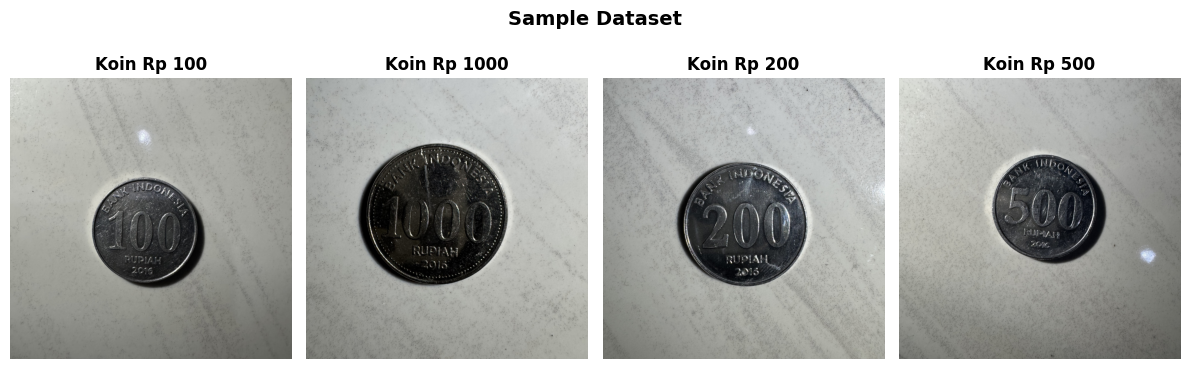

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for idx, cls_name in enumerate(class_names):
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(cls_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Sample Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Eksperimen: Binarization vs Grayscale untuk Edge Detection

Membandingkan hasil edge detection dengan preprocessing binarization (Otsu) vs grayscale tradisional.

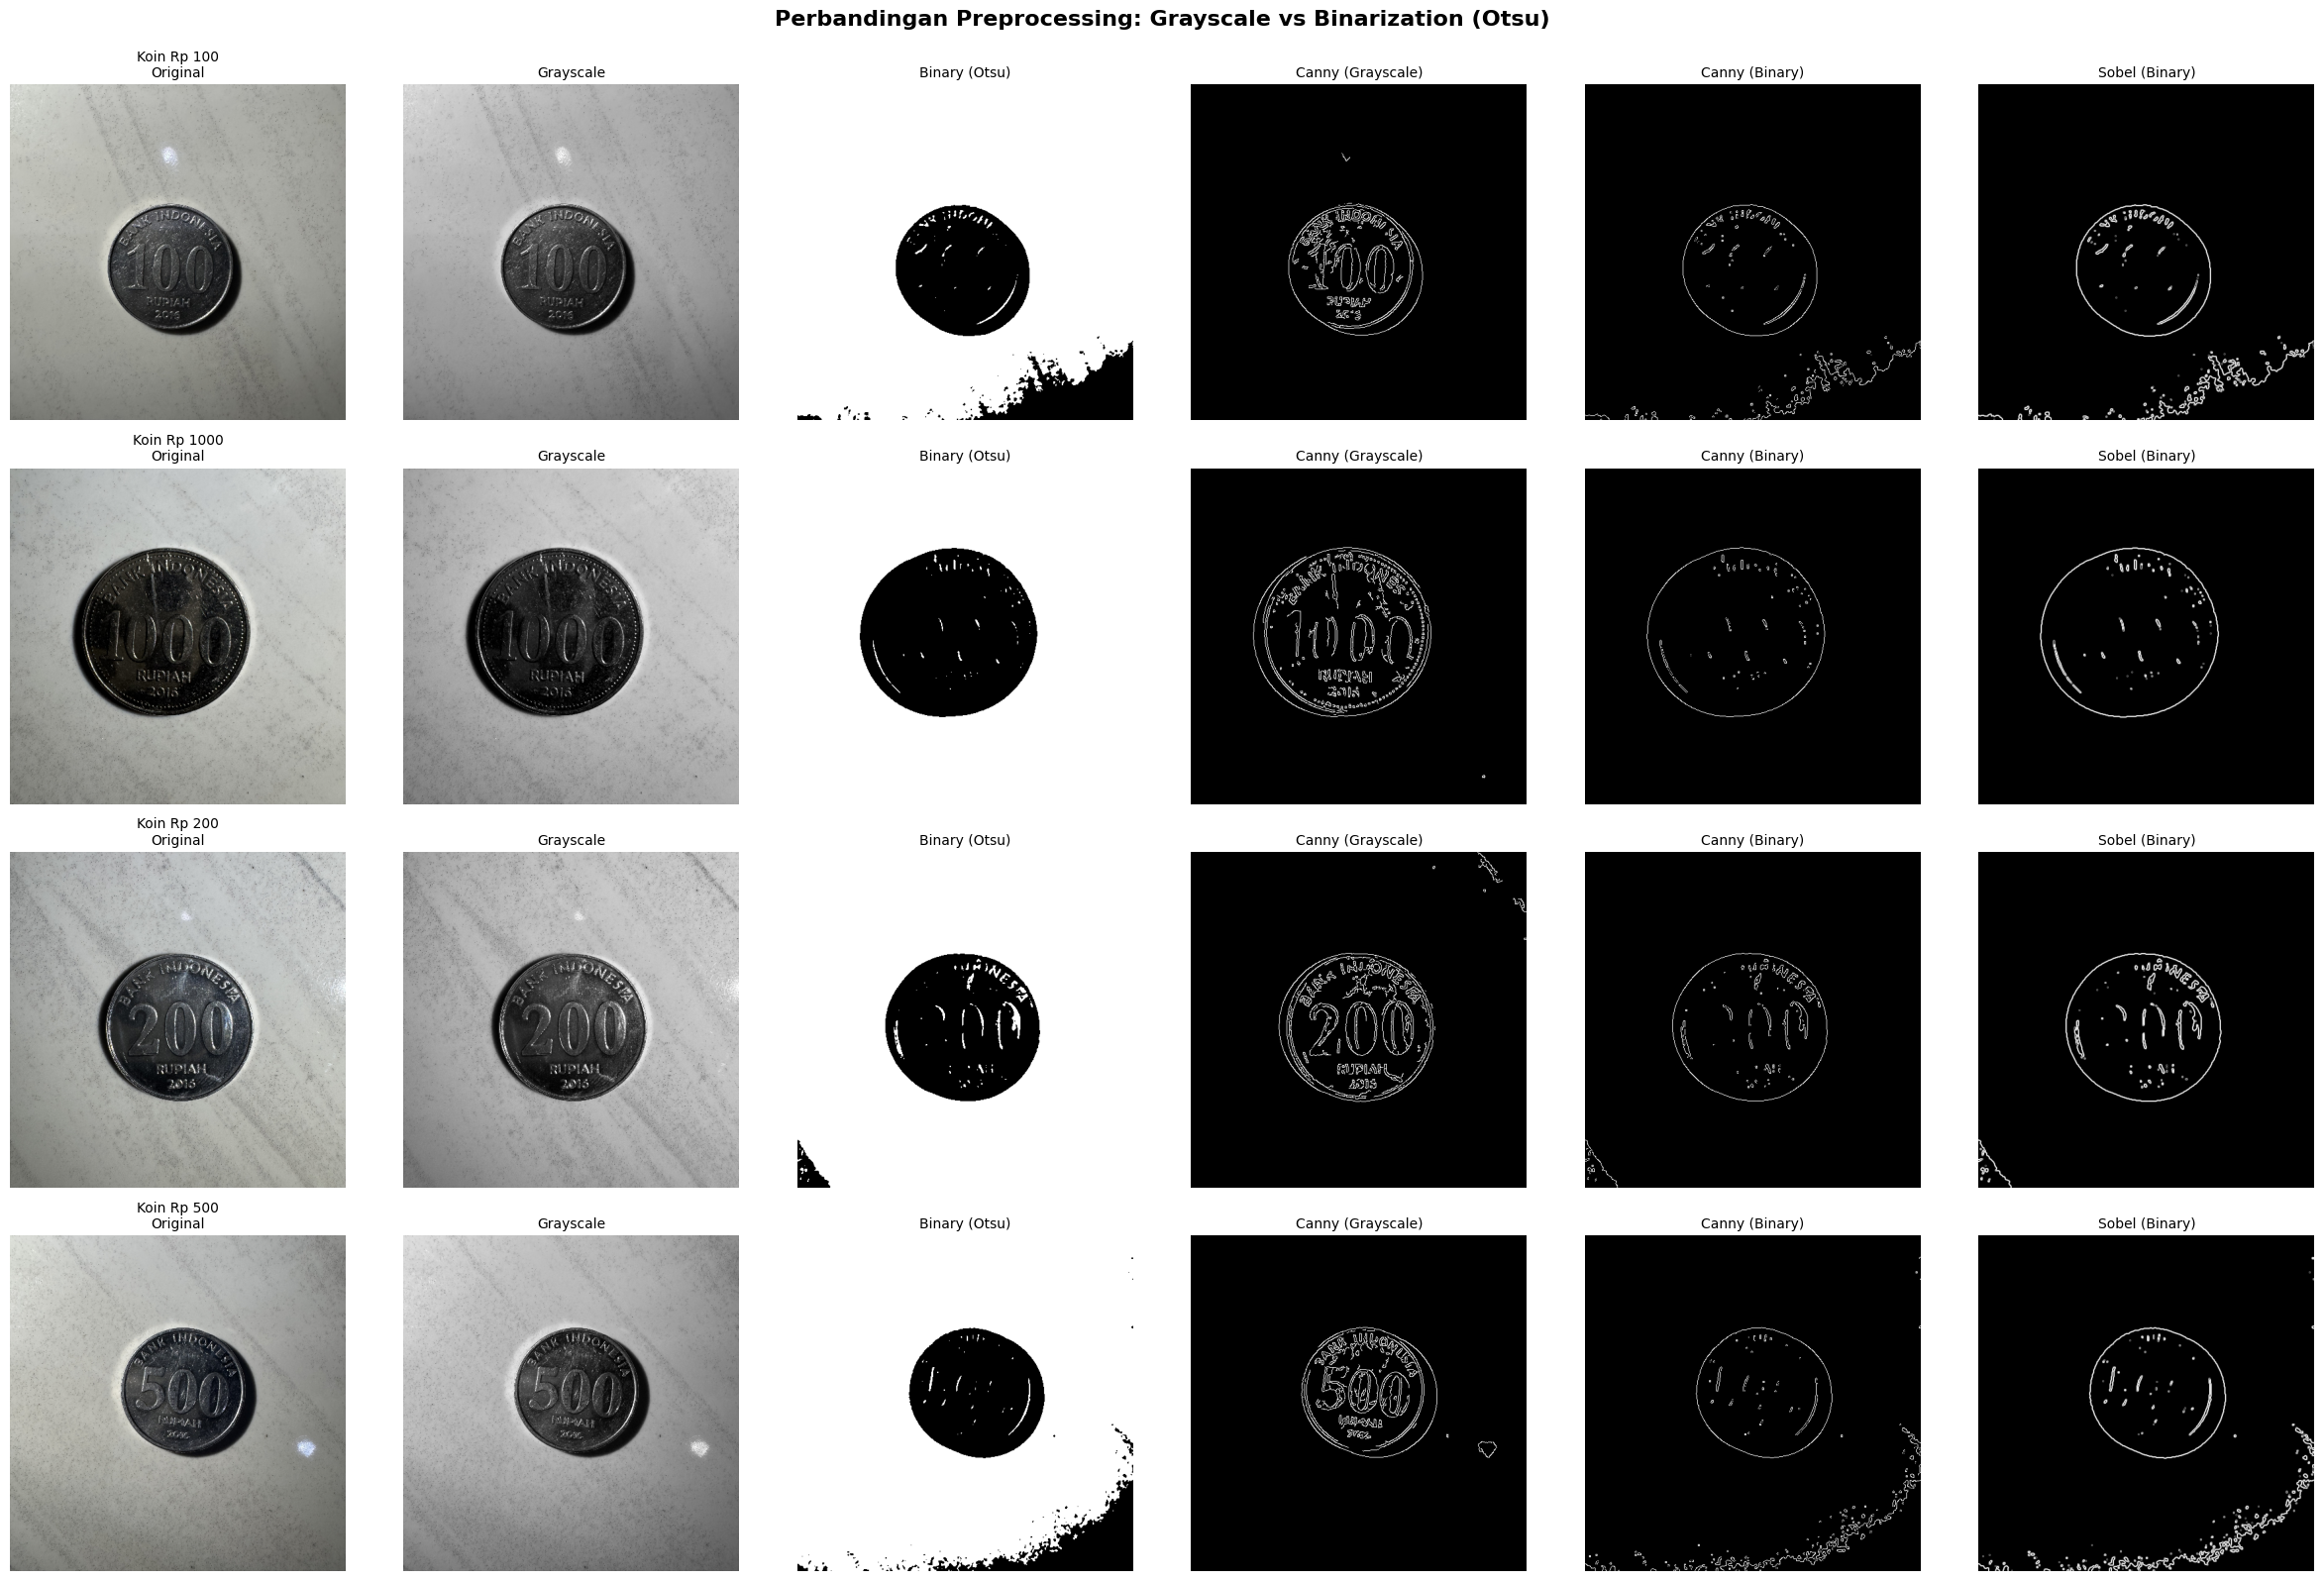

In [8]:
# Visualize Binarization vs Grayscale preprocessing
fig, axes = plt.subplots(len(class_names), 6, figsize=(24, len(class_names) * 4))

for idx, cls_name in enumerate(class_names):
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, IMAGE_SIZE)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        
        # Get binary image for visualization
        binary = apply_binarization(img_resized, method='otsu')
        
        # Edge detection with Grayscale (traditional)
        edges_gray = apply_canny_edge(img_resized, use_binary=False)
        
        # Edge detection with Binarization (Otsu)
        edges_binary = apply_canny_edge(img_resized, use_binary=True, binary_method='otsu')
        
        # Sobel with Binarization
        sobel_binary = apply_sobel_edge(img_resized, use_binary=True, binary_method='otsu')
        
        # Plot
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title(f'{cls_name}\nOriginal', fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gray, cmap='gray')
        axes[idx, 1].set_title('Grayscale', fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(binary, cmap='gray')
        axes[idx, 2].set_title('Binary (Otsu)', fontsize=10)
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(edges_gray, cmap='gray')
        axes[idx, 3].set_title('Canny (Grayscale)', fontsize=10)
        axes[idx, 3].axis('off')
        
        axes[idx, 4].imshow(edges_binary, cmap='gray')
        axes[idx, 4].set_title('Canny (Binary)', fontsize=10)
        axes[idx, 4].axis('off')
        
        axes[idx, 5].imshow(sobel_binary, cmap='gray')
        axes[idx, 5].set_title('Sobel (Binary)', fontsize=10)
        axes[idx, 5].axis('off')

plt.suptitle('Perbandingan Preprocessing: Grayscale vs Binarization (Otsu)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 9. Load dan Extract Features (Dengan Augmentation)

In [9]:
def load_and_extract_features(dataset_dir, class_names, edge_method='canny', 
                              apply_augmentation=False, max_images=None,
                              use_binary=True, binary_method='otsu'):
    """
    Load images and extract features from CROPPED version only
    
    Returns 35 features per sample from cropped coin (normalized texture)
    
    Args:
        dataset_dir: Path to dataset directory
        class_names: List of class names
        edge_method: 'canny' or 'sobel'
        apply_augmentation: Whether to apply data augmentation
        max_images: Maximum images per class (None = no limit)
        use_binary: Use binarization instead of grayscale
        binary_method: 'otsu', 'adaptive_mean', 'adaptive_gaussian', or 'fixed'
    
    Returns:
        X: Feature matrix
        y: Labels
    """
    import sys
    sys.path.insert(0, str(Path('..').resolve()))
    from preprocessing import crop_coin_to_circle
    
    X = []
    y = []
    
    for label, cls_name in enumerate(class_names):
        cls_dir = dataset_dir / cls_name
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
        
        # Limit images per class if specified
        if max_images is not None and len(images) > max_images:
            np.random.shuffle(images)
            images = images[:max_images]
        
        print(f"Processing {cls_name}: {len(images)} images", end='')
        
        success_count = 0
        for img_path in images:
            # Load and resize
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_resized = cv2.resize(img, IMAGE_SIZE)
            
            # Apply augmentation if enabled
            if apply_augmentation:
                augmented_images = augment_image(img_resized)
            else:
                augmented_images = [img_resized]
            
            # Extract features from each augmented image
            for aug_img in augmented_images:
                # 1. Detect circle on original image
                segmented_original, circle_info, _ = detect_and_segment_coin(
                    aug_img, edge_method, use_binary=use_binary, binary_method=binary_method
                )
                
                # Only add if circle detected (for better quality)
                if circle_info is not None:
                    # 2. Crop to circle diameter and resize
                    cropped = crop_coin_to_circle(segmented_original, circle_info, IMAGE_SIZE)
                    
                    # 3. Apply edge detection to cropped version (with binarization)
                    if edge_method == 'canny':
                        edges_cropped = apply_canny_edge(cropped, use_binary=use_binary, binary_method=binary_method)
                    else:
                        edges_cropped = apply_sobel_edge(cropped, use_binary=use_binary, binary_method=binary_method)
                    
                    # 4. Extract features from CROPPED version only (35 features)
                    # Circle info for cropped image (centered)
                    h, w = cropped.shape[:2]
                    circle_info_cropped = (w//2, h//2, min(w, h)//2)
                    
                    features = extract_coin_features(cropped, edges_cropped, circle_info_cropped)
                    
                    X.append(features)
                    y.append(label)
                    success_count += 1
        
        preprocessing = "Binary" if use_binary else "Grayscale"
        if apply_augmentation:
            print(f" -> {success_count} samples ({preprocessing}, augmented)")
        else:
            print(f" -> {success_count} samples ({preprocessing})")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

### 9.1 Extract Features dengan Canny + Binarization (Otsu)

Using binarization (Otsu's thresholding) instead of grayscale for enhanced edge detection.

In [10]:
print("="*70)
print("CANNY + BINARIZATION (OTSU) + CROPPING + AUGMENTATION")
print("="*70)

# Extract features with Canny + Binarization
X_canny, y_canny = load_and_extract_features(
    DATASET_DIR, 
    class_names, 
    edge_method='canny',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS,
    use_binary=True,
    binary_method='otsu'
)

print(f"\nTotal samples (Canny + Binary): {len(X_canny)}")
print(f"Feature dimensions: {X_canny.shape[1]}")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_canny, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

CANNY + BINARIZATION (OTSU) + CROPPING + AUGMENTATION
Processing Koin Rp 100: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 1000: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 1000: 150 images -> 1193 samples (Binary, augmented)
Processing Koin Rp 200: 150 images -> 1193 samples (Binary, augmented)
Processing Koin Rp 200: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (Binary, augmented)

Total samples (Canny + Binary): 4793
Feature dimensions: 35
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1193 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples
 -> 1200 samples (Binary, augmented)

Total samples (Canny + Binary): 4793
Feature dimensions: 35
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1193 samples
  Koin Rp 200: 1200 samples
  Koin Rp 50

### 9.2 Extract Features dengan Sobel + Binarization (Otsu)

Using binarization (Otsu's thresholding) instead of grayscale for enhanced edge detection.

In [11]:
print("="*70)
print("SOBEL + BINARIZATION (OTSU) + CROPPING + AUGMENTATION")
print("="*70)

# Extract features with Sobel + Binarization
X_sobel, y_sobel = load_and_extract_features(
    DATASET_DIR, 
    class_names, 
    edge_method='sobel',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS,
    use_binary=True,
    binary_method='otsu'
)

print(f"\nTotal samples (Sobel + Binary): {len(X_sobel)}")
print(f"Feature dimensions: {X_sobel.shape[1]}")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_sobel, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

SOBEL + BINARIZATION (OTSU) + CROPPING + AUGMENTATION
Processing Koin Rp 100: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 1000: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 1000: 150 images -> 1194 samples (Binary, augmented)
Processing Koin Rp 200: 150 images -> 1194 samples (Binary, augmented)
Processing Koin Rp 200: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (Binary, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (Binary, augmented)

Total samples (Sobel + Binary): 4794
Feature dimensions: 35
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1194 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples
 -> 1200 samples (Binary, augmented)

Total samples (Sobel + Binary): 4794
Feature dimensions: 35
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1194 samples
  Koin Rp 200: 1200 samples
  Koin Rp 50

## 10. Split Data Training dan Testing

In [12]:
# Split data for Canny
X_train_canny, X_test_canny, y_train_canny, y_test_canny = train_test_split(
    X_canny, y_canny, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_canny
)

print("CANNY Edge Detection:")
print(f"  Training set: {X_train_canny.shape[0]} samples")
print(f"  Testing set: {X_test_canny.shape[0]} samples")

# Split data for Sobel
X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(
    X_sobel, y_sobel, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_sobel
)

print("\nSOBEL Edge Detection:")
print(f"  Training set: {X_train_sobel.shape[0]} samples")
print(f"  Testing set: {X_test_sobel.shape[0]} samples")

CANNY Edge Detection:
  Training set: 3834 samples
  Testing set: 959 samples

SOBEL Edge Detection:
  Training set: 3835 samples
  Testing set: 959 samples


## 11. Model Training: Random Forest

Melatih model Random Forest dengan features dari Canny dan Sobel edge detection.

### 11.1 Random Forest + Canny

In [13]:
print("Training Random Forest + Canny...")

scaler_rf_canny = StandardScaler()
X_train_canny_scaled = scaler_rf_canny.fit_transform(X_train_canny)
X_test_canny_scaled = scaler_rf_canny.transform(X_test_canny)

rf_canny = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_rf_canny = rf_canny.predict(X_test_canny_scaled)
acc_rf_canny = accuracy_score(y_test_canny, y_pred_rf_canny)

print(f"Accuracy: {acc_rf_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_rf_canny, target_names=class_names))

Training Random Forest + Canny...
Accuracy: 0.8175

              precision    recall  f1-score   support

 Koin Rp 100       0.82      0.82      0.82       240
Koin Rp 1000       0.79      0.81      0.80       239
 Koin Rp 200       0.87      0.83      0.85       240
 Koin Rp 500       0.79      0.82      0.80       240

    accuracy                           0.82       959
   macro avg       0.82      0.82      0.82       959
weighted avg       0.82      0.82      0.82       959

Accuracy: 0.8175

              precision    recall  f1-score   support

 Koin Rp 100       0.82      0.82      0.82       240
Koin Rp 1000       0.79      0.81      0.80       239
 Koin Rp 200       0.87      0.83      0.85       240
 Koin Rp 500       0.79      0.82      0.80       240

    accuracy                           0.82       959
   macro avg       0.82      0.82      0.82       959
weighted avg       0.82      0.82      0.82       959



### 11.2 Random Forest + Sobel

In [14]:
print("Training Random Forest + Sobel...")

scaler_rf_sobel = StandardScaler()
X_train_sobel_scaled = scaler_rf_sobel.fit_transform(X_train_sobel)
X_test_sobel_scaled = scaler_rf_sobel.transform(X_test_sobel)

rf_sobel = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_rf_sobel = rf_sobel.predict(X_test_sobel_scaled)
acc_rf_sobel = accuracy_score(y_test_sobel, y_pred_rf_sobel)

print(f"Accuracy: {acc_rf_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_rf_sobel, target_names=class_names))

Training Random Forest + Sobel...
Accuracy: 0.8227

              precision    recall  f1-score   support

 Koin Rp 100       0.76      0.83      0.80       240
Koin Rp 1000       0.82      0.82      0.82       239
 Koin Rp 200       0.88      0.83      0.86       240
 Koin Rp 500       0.83      0.80      0.82       240

    accuracy                           0.82       959
   macro avg       0.83      0.82      0.82       959
weighted avg       0.83      0.82      0.82       959

Accuracy: 0.8227

              precision    recall  f1-score   support

 Koin Rp 100       0.76      0.83      0.80       240
Koin Rp 1000       0.82      0.82      0.82       239
 Koin Rp 200       0.88      0.83      0.86       240
 Koin Rp 500       0.83      0.80      0.82       240

    accuracy                           0.82       959
   macro avg       0.83      0.82      0.82       959
weighted avg       0.83      0.82      0.82       959



## 12. Model Training: Support Vector Machine (SVM)

### 12.1 SVM + Canny

In [15]:
print("Training SVM + Canny...")

svm_canny = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_svm_canny = svm_canny.predict(X_test_canny_scaled)
acc_svm_canny = accuracy_score(y_test_canny, y_pred_svm_canny)

print(f"Accuracy: {acc_svm_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_svm_canny, target_names=class_names))

Training SVM + Canny...
Accuracy: 0.7550

              precision    recall  f1-score   support

 Koin Rp 100       0.70      0.77      0.73       240
Koin Rp 1000       0.81      0.72      0.76       239
 Koin Rp 200       0.78      0.82      0.80       240
 Koin Rp 500       0.74      0.71      0.72       240

    accuracy                           0.75       959
   macro avg       0.76      0.75      0.75       959
weighted avg       0.76      0.75      0.75       959

Accuracy: 0.7550

              precision    recall  f1-score   support

 Koin Rp 100       0.70      0.77      0.73       240
Koin Rp 1000       0.81      0.72      0.76       239
 Koin Rp 200       0.78      0.82      0.80       240
 Koin Rp 500       0.74      0.71      0.72       240

    accuracy                           0.75       959
   macro avg       0.76      0.75      0.75       959
weighted avg       0.76      0.75      0.75       959



### 12.2 SVM + Sobel

In [16]:
print("Training SVM + Sobel...")

svm_sobel = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_svm_sobel = svm_sobel.predict(X_test_sobel_scaled)
acc_svm_sobel = accuracy_score(y_test_sobel, y_pred_svm_sobel)

print(f"Accuracy: {acc_svm_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_svm_sobel, target_names=class_names))

Training SVM + Sobel...
Accuracy: 0.7550

              precision    recall  f1-score   support

 Koin Rp 100       0.67      0.72      0.69       240
Koin Rp 1000       0.83      0.71      0.77       239
 Koin Rp 200       0.79      0.85      0.82       240
 Koin Rp 500       0.74      0.75      0.74       240

    accuracy                           0.75       959
   macro avg       0.76      0.75      0.76       959
weighted avg       0.76      0.75      0.76       959

Accuracy: 0.7550

              precision    recall  f1-score   support

 Koin Rp 100       0.67      0.72      0.69       240
Koin Rp 1000       0.83      0.71      0.77       239
 Koin Rp 200       0.79      0.85      0.82       240
 Koin Rp 500       0.74      0.75      0.74       240

    accuracy                           0.75       959
   macro avg       0.76      0.75      0.76       959
weighted avg       0.76      0.75      0.76       959



## 13. Perbandingan Hasil Semua Model

In [17]:
comparison_df = pd.DataFrame({
    'Model': [
        'Random Forest + Canny',
        'Random Forest + Sobel',
        'SVM + Canny',
        'SVM + Sobel'
    ],
    'Edge Detection': ['Canny', 'Sobel', 'Canny', 'Sobel'],
    'Preprocessing': ['Binary (Otsu)', 'Binary (Otsu)', 'Binary (Otsu)', 'Binary (Otsu)'],
    'Classifier': ['Random Forest', 'Random Forest', 'SVM', 'SVM'],
    'Accuracy': [acc_rf_canny, acc_rf_sobel, acc_svm_canny, acc_svm_sobel]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("MODEL COMPARISON (Using Binarization Preprocessing)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print(f"\nBEST MODEL: {comparison_df.iloc[0]['Model']}")
print(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)")
print(f"  Preprocessing: {comparison_df.iloc[0]['Preprocessing']}")
print("="*80)

MODEL COMPARISON (Using Binarization Preprocessing)
                Model Edge Detection Preprocessing    Classifier  Accuracy
Random Forest + Sobel          Sobel Binary (Otsu) Random Forest  0.822732
Random Forest + Canny          Canny Binary (Otsu) Random Forest  0.817518
          SVM + Canny          Canny Binary (Otsu)           SVM  0.754953
          SVM + Sobel          Sobel Binary (Otsu)           SVM  0.754953

BEST MODEL: Random Forest + Sobel
  Accuracy: 0.8227 (82.27%)
  Preprocessing: Binary (Otsu)


### 13.1 Visualisasi Perbandingan Accuracy

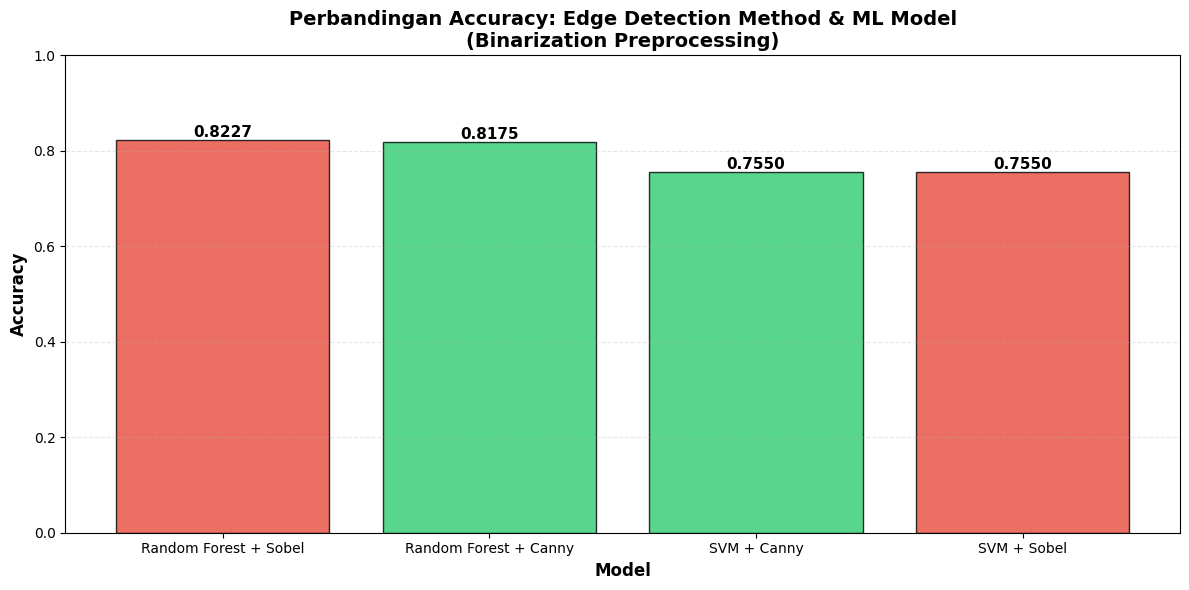

In [18]:
# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71' if 'Canny' in model else '#e74c3c' for model in comparison_df['Model']]
bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Accuracy: Edge Detection Method & ML Model\n(Binarization Preprocessing)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 13.2 Feature Importance Analysis

Analyze which features contribute most to classification to determine if we can reduce the feature set.

In [19]:
# Define feature names for interpretability
feature_names = [
    # Texture Features (12)
    'edge_density',
    'edge_mean', 'edge_std', 'edge_max',
    'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
    'edge_hist_4', 'edge_hist_5', 'edge_hist_6', 'edge_hist_7',
    
    # Shape Features (4)
    'normalized_radius', 'center_x', 'center_y', 'circularity',
    
    # Edge Pattern Features (12)
    'orient_hist_0', 'orient_hist_1', 'orient_hist_2', 'orient_hist_3',
    'orient_hist_4', 'orient_hist_5', 'orient_hist_6', 'orient_hist_7',
    'magnitude_mean', 'magnitude_std', 'magnitude_p75', 'magnitude_p90',
    
    # Spatial Features (4)
    'quad_density_tl', 'quad_density_tr', 'quad_density_bl', 'quad_density_br',
    
    # Local Variance Features (3)
    'local_var_mean', 'local_var_std', 'local_var_p75'
]

print(f"Total features defined: {len(feature_names)}")

# Get feature importance from best Random Forest model (Sobel)
importances = rf_sobel.feature_importances_
indices = np.argsort(importances)[::-1]

# Create DataFrame for analysis
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in indices],
    'Importance': importances[indices],
    'Rank': range(1, len(feature_names) + 1)
})

# Calculate cumulative importance
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Cumulative_Pct'] = importance_df['Cumulative'] / importance_df['Importance'].sum() * 100

print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKING (Random Forest + Sobel)")
print("="*70)
print(importance_df.to_string(index=False))
print("="*70)

Total features defined: 35

FEATURE IMPORTANCE RANKING (Random Forest + Sobel)
          Feature  Importance  Rank  Cumulative  Cumulative_Pct
    magnitude_p75    0.062955     1    0.062955        6.295490
    magnitude_std    0.059902     2    0.122857       12.285688
      circularity    0.055104     3    0.177960       17.796039
    local_var_std    0.054877     4    0.232838       23.283761
    magnitude_p90    0.049279     5    0.282116       28.211634
   magnitude_mean    0.045324     6    0.327440       32.744018
    local_var_p75    0.043563     7    0.371003       37.100325
   local_var_mean    0.039934     8    0.410937       41.093746
      edge_hist_7    0.037314     9    0.448251       44.825141
      edge_hist_3    0.036107    10    0.484359       48.435889
         edge_std    0.036041    11    0.520400       52.039972
    orient_hist_1    0.034891    12    0.555291       55.529102
        edge_mean    0.033764    13    0.589055       58.905513
    orient_hist_3    0.03

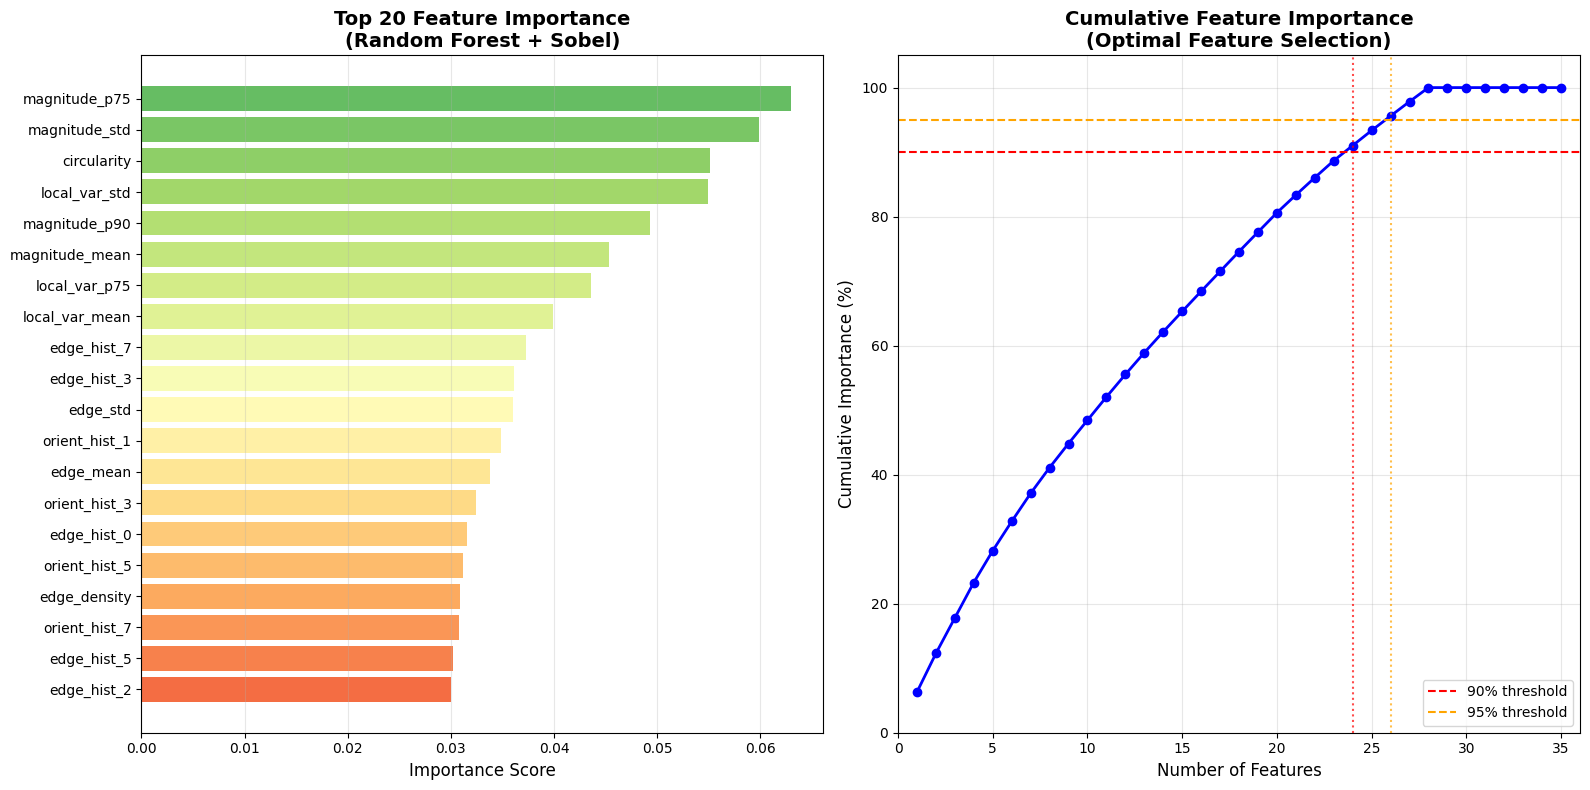


FEATURE SELECTION RECOMMENDATIONS:
   • Top 24 features capture 90% importance
   • Top 26 features capture 95% importance
   • Total features: 35


In [20]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Feature Importance Bar Chart (Top 20)
top_n = 20
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))
axes[0].barh(range(top_n), importance_df['Importance'].values[:top_n][::-1], color=colors[::-1])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(importance_df['Feature'].values[:top_n][::-1])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title(f'Top {top_n} Feature Importance\n(Random Forest + Sobel)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Cumulative Importance
axes[1].plot(range(1, len(feature_names) + 1), importance_df['Cumulative_Pct'].values, 
             'b-o', markersize=6, linewidth=2)
axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=95, color='orange', linestyle='--', label='95% threshold')

# Find optimal cutoffs
n_features_90 = (importance_df['Cumulative_Pct'] >= 90).idxmax() + 1
n_features_95 = (importance_df['Cumulative_Pct'] >= 95).idxmax() + 1

axes[1].axvline(x=n_features_90, color='r', linestyle=':', alpha=0.7)
axes[1].axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.7)

axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[1].set_title('Cumulative Feature Importance\n(Optimal Feature Selection)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, len(feature_names) + 1)
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

print(f"\nFEATURE SELECTION RECOMMENDATIONS:")
print(f"   • Top {n_features_90} features capture 90% importance")
print(f"   • Top {n_features_95} features capture 95% importance")
print(f"   • Total features: {len(feature_names)}")

## 14. Confusion Matrix untuk Model Terbaik

Model terbaik: Random Forest + Sobel
Accuracy: 0.8227



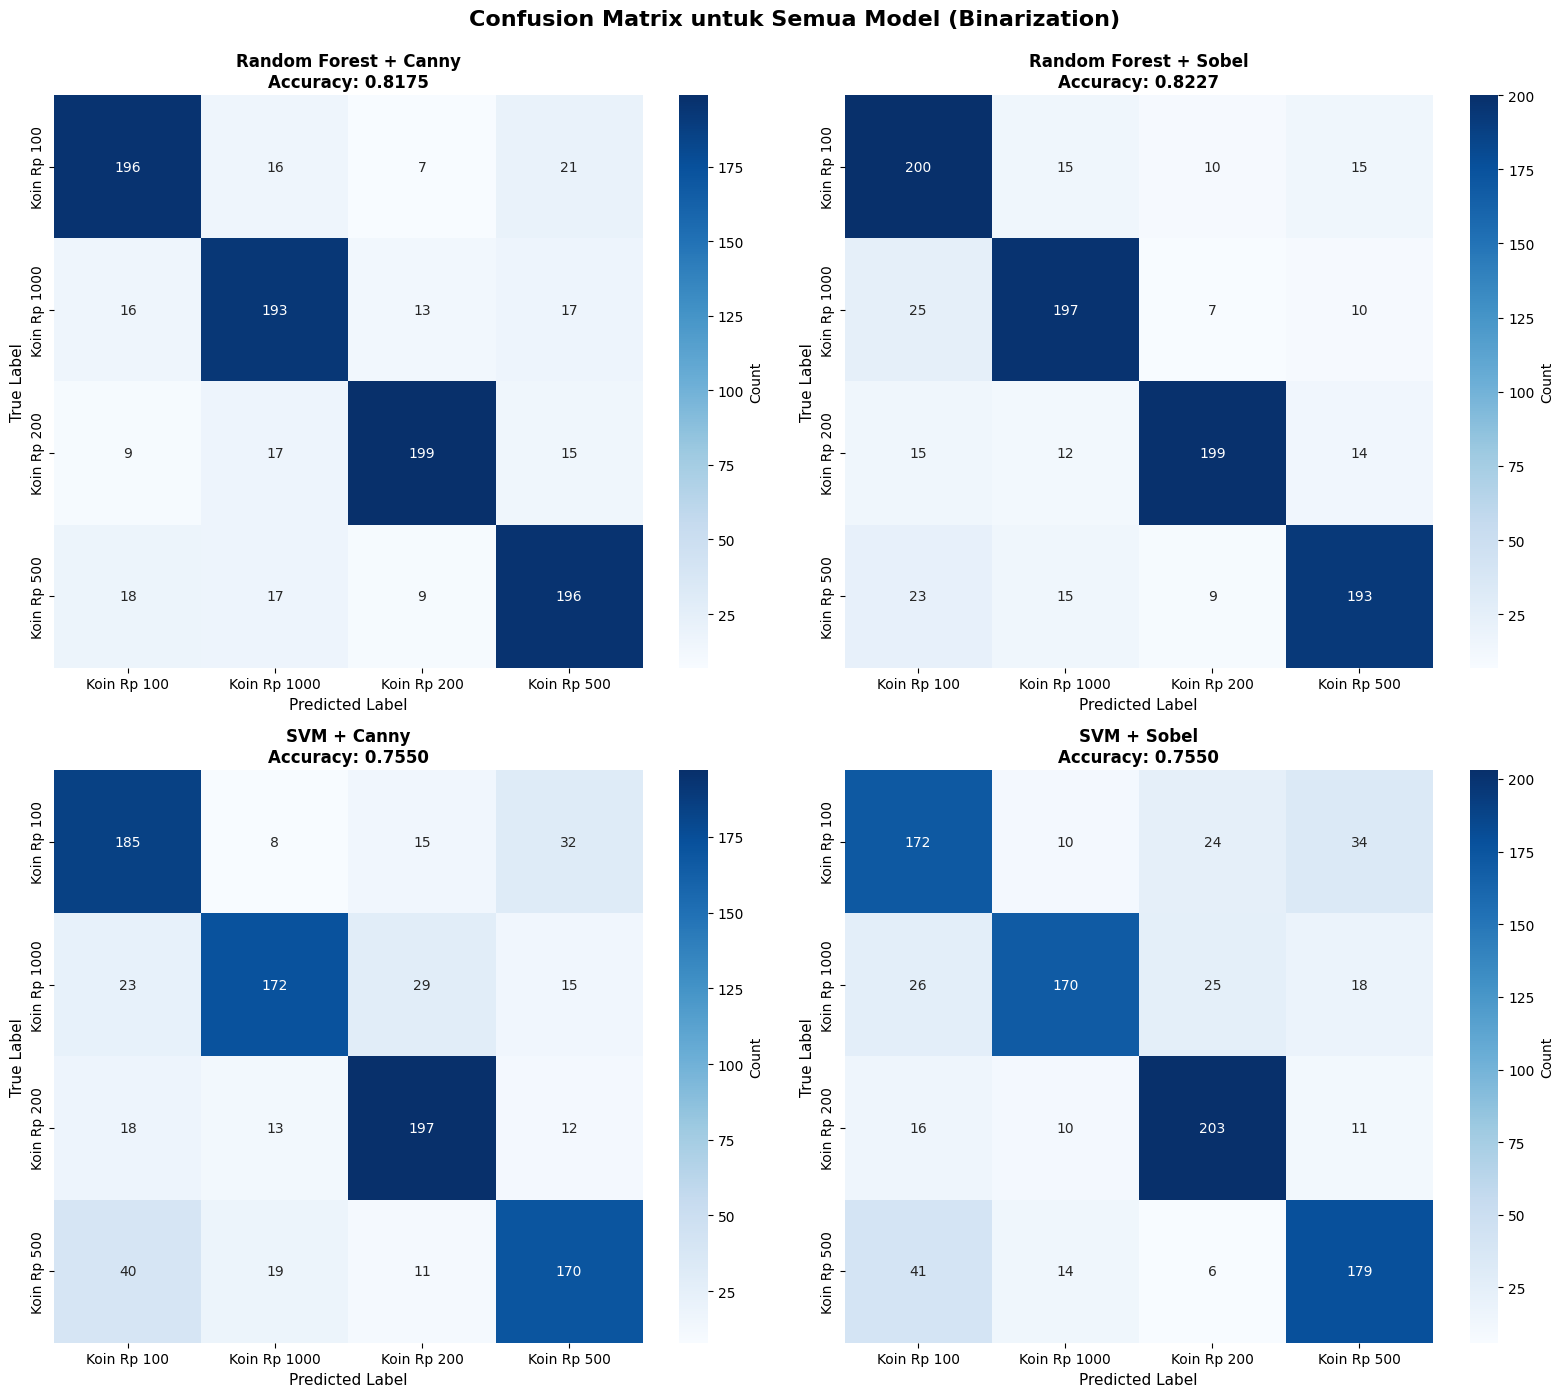

In [21]:
# Determine best model
best_model_row = comparison_df.iloc[0]
print(f"Model terbaik: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}\n")

# Get predictions for all models
models_info = [
    ('Random Forest + Canny', y_test_canny, y_pred_rf_canny),
    ('Random Forest + Sobel', y_test_sobel, y_pred_rf_sobel),
    ('SVM + Canny', y_test_canny, y_pred_svm_canny),
    ('SVM + Sobel', y_test_sobel, y_pred_svm_sobel)
]

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, y_true, y_pred) in enumerate(models_info):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy_score(y_true, y_pred):.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=11)

plt.suptitle('Confusion Matrix untuk Semua Model (Binarization)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 15. Analisis Per-Class Performance

In [22]:
from sklearn.metrics import precision_recall_fscore_support

models_info = [
    ('Random Forest + Canny', y_test_canny, y_pred_rf_canny),
    ('Random Forest + Sobel', y_test_sobel, y_pred_rf_sobel),
    ('SVM + Canny', y_test_canny, y_pred_svm_canny),
    ('SVM + Sobel', y_test_sobel, y_pred_svm_sobel)
]

per_class_results = []

for model_name, y_true, y_pred in models_info:
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )
    
    for idx, cls_name in enumerate(class_names):
        per_class_results.append({
            'Model': model_name,
            'Class': cls_name,
            'Precision': precision[idx],
            'Recall': recall[idx],
            'F1-Score': f1[idx],
            'Support': support[idx]
        })

per_class_df = pd.DataFrame(per_class_results)

for cls_name in class_names:
    print(f"\n{cls_name}:")
    cls_data = per_class_df[per_class_df['Class'] == cls_name]
    print(cls_data[['Model', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))


Koin Rp 100:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.820084 0.816667  0.818372
Random Forest + Sobel   0.760456 0.833333  0.795229
          SVM + Canny   0.695489 0.770833  0.731225
          SVM + Sobel   0.674510 0.716667  0.694949

Koin Rp 1000:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.794239 0.807531  0.800830
Random Forest + Sobel   0.824268 0.824268  0.824268
          SVM + Canny   0.811321 0.719665  0.762749
          SVM + Sobel   0.833333 0.711297  0.767494

Koin Rp 200:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.872807 0.829167  0.850427
Random Forest + Sobel   0.884444 0.829167  0.855914
          SVM + Canny   0.781746 0.820833  0.800813
          SVM + Sobel   0.786822 0.845833  0.815261

Koin Rp 500:
                Model  Precision   Recall  F1-Score
Random Forest + Canny   0.787149 0.816667  0.801636
Random Forest + Sobel   0.831897 0.804167  0.817797
       

### 15.1 Visualisasi F1-Score per Class

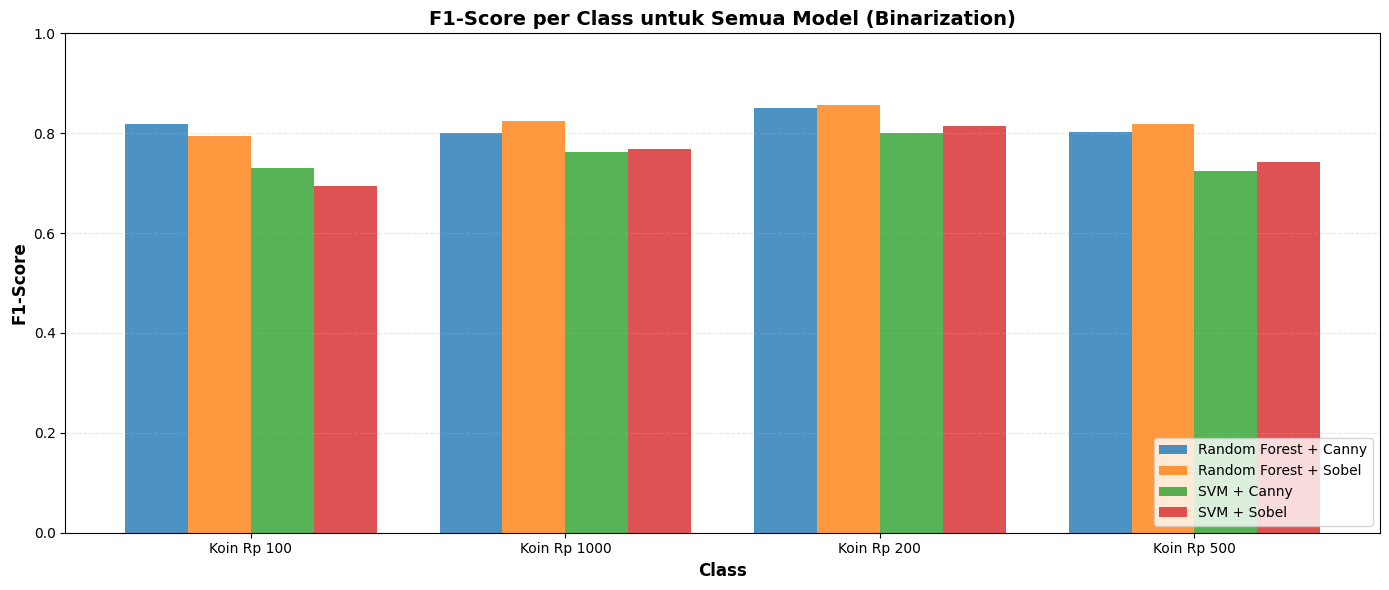

In [23]:
# Plot F1-Score per class for all models
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.2

for idx, (model_name, _, _) in enumerate(models_info):
    model_data = per_class_df[per_class_df['Model'] == model_name]
    f1_scores = model_data['F1-Score'].values
    
    offset = (idx - 1.5) * width
    ax.bar(x + offset, f1_scores, width, label=model_name, alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score per Class untuk Semua Model (Binarization)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=0)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## Analisis Kesalahan Prediksi

Analisis model terbaik (Random Forest + Sobel) untuk memahami karakteristik misclassification.

In [24]:
misclassified_indices = np.where(y_test_sobel != y_pred_rf_sobel)[0]
correct_indices = np.where(y_test_sobel == y_pred_rf_sobel)[0]

print(f"Total test samples: {len(y_test_sobel)}")
print(f"Correct: {len(correct_indices)} ({len(correct_indices)/len(y_test_sobel)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_test_sobel)*100:.2f}%)")

print("\nBreakdown per kelas:")
for cls_idx, cls_name in enumerate(class_names):
    class_mask = y_test_sobel == cls_idx
    class_total = np.sum(class_mask)
    class_misclassified = np.sum((y_test_sobel == cls_idx) & (y_pred_rf_sobel != cls_idx))
    
    print(f"  {cls_name}: {class_total} total, {class_misclassified} misclassified ({class_misclassified/class_total*100:.2f}%)")
    
    if class_misclassified > 0:
        misclass_mask = (y_test_sobel == cls_idx) & (y_pred_rf_sobel != cls_idx)
        predicted_as = y_pred_rf_sobel[misclass_mask]
        for pred_idx in range(len(class_names)):
            pred_count = np.sum(predicted_as == pred_idx)
            if pred_count > 0:
                print(f"      → {pred_count}x as {class_names[pred_idx]}")

Total test samples: 959
Correct: 789 (82.27%)
Misclassified: 170 (17.73%)

Breakdown per kelas:
  Koin Rp 100: 240 total, 40 misclassified (16.67%)
      → 15x as Koin Rp 1000
      → 10x as Koin Rp 200
      → 15x as Koin Rp 500
  Koin Rp 1000: 239 total, 42 misclassified (17.57%)
      → 25x as Koin Rp 100
      → 7x as Koin Rp 200
      → 10x as Koin Rp 500
  Koin Rp 200: 240 total, 41 misclassified (17.08%)
      → 15x as Koin Rp 100
      → 12x as Koin Rp 1000
      → 14x as Koin Rp 500
  Koin Rp 500: 240 total, 47 misclassified (19.58%)
      → 23x as Koin Rp 100
      → 15x as Koin Rp 1000
      → 9x as Koin Rp 200


In [25]:
def get_sample_images_for_misclassifications(dataset_dir, class_names, y_test, y_pred, 
                                              max_samples_per_class=3, edge_method='sobel'):
    """Get sample images for misclassified predictions"""
    misclass_indices = np.where(y_test != y_pred)[0]
    samples_per_class = {cls_idx: [] for cls_idx in range(len(class_names))}
    
    for idx in misclass_indices:
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        samples_per_class[true_label].append((true_label, pred_label))
    
    result = []
    
    for cls_idx, cls_name in enumerate(class_names):
        if len(samples_per_class[cls_idx]) == 0:
            continue
        
        cls_dir = dataset_dir / cls_name
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
        
        if len(images) == 0:
            continue
        
        num_samples = min(max_samples_per_class, len(samples_per_class[cls_idx]))
        
        for i in range(num_samples):
            if i < len(samples_per_class[cls_idx]):
                true_label, pred_label = samples_per_class[cls_idx][i]
                
                np.random.seed(RANDOM_SEED + cls_idx + i)
                img_path = np.random.choice(images)
                
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, IMAGE_SIZE)
                seg, circle_info, edges = detect_and_segment_coin(img_resized, edge_method)
                
                if circle_info is not None:
                    result.append({
                        'image': img_resized,
                        'true_label': true_label,
                        'pred_label': pred_label,
                        'edges': edges,
                        'circle_info': circle_info
                    })
    
    return result

In [26]:
misclassified_samples = get_sample_images_for_misclassifications(
    DATASET_DIR, class_names, y_test_sobel, y_pred_rf_sobel,
    max_samples_per_class=2, edge_method='sobel'
)

print(f"Visualizing {len(misclassified_samples)} misclassified samples...")

Visualizing 8 misclassified samples...


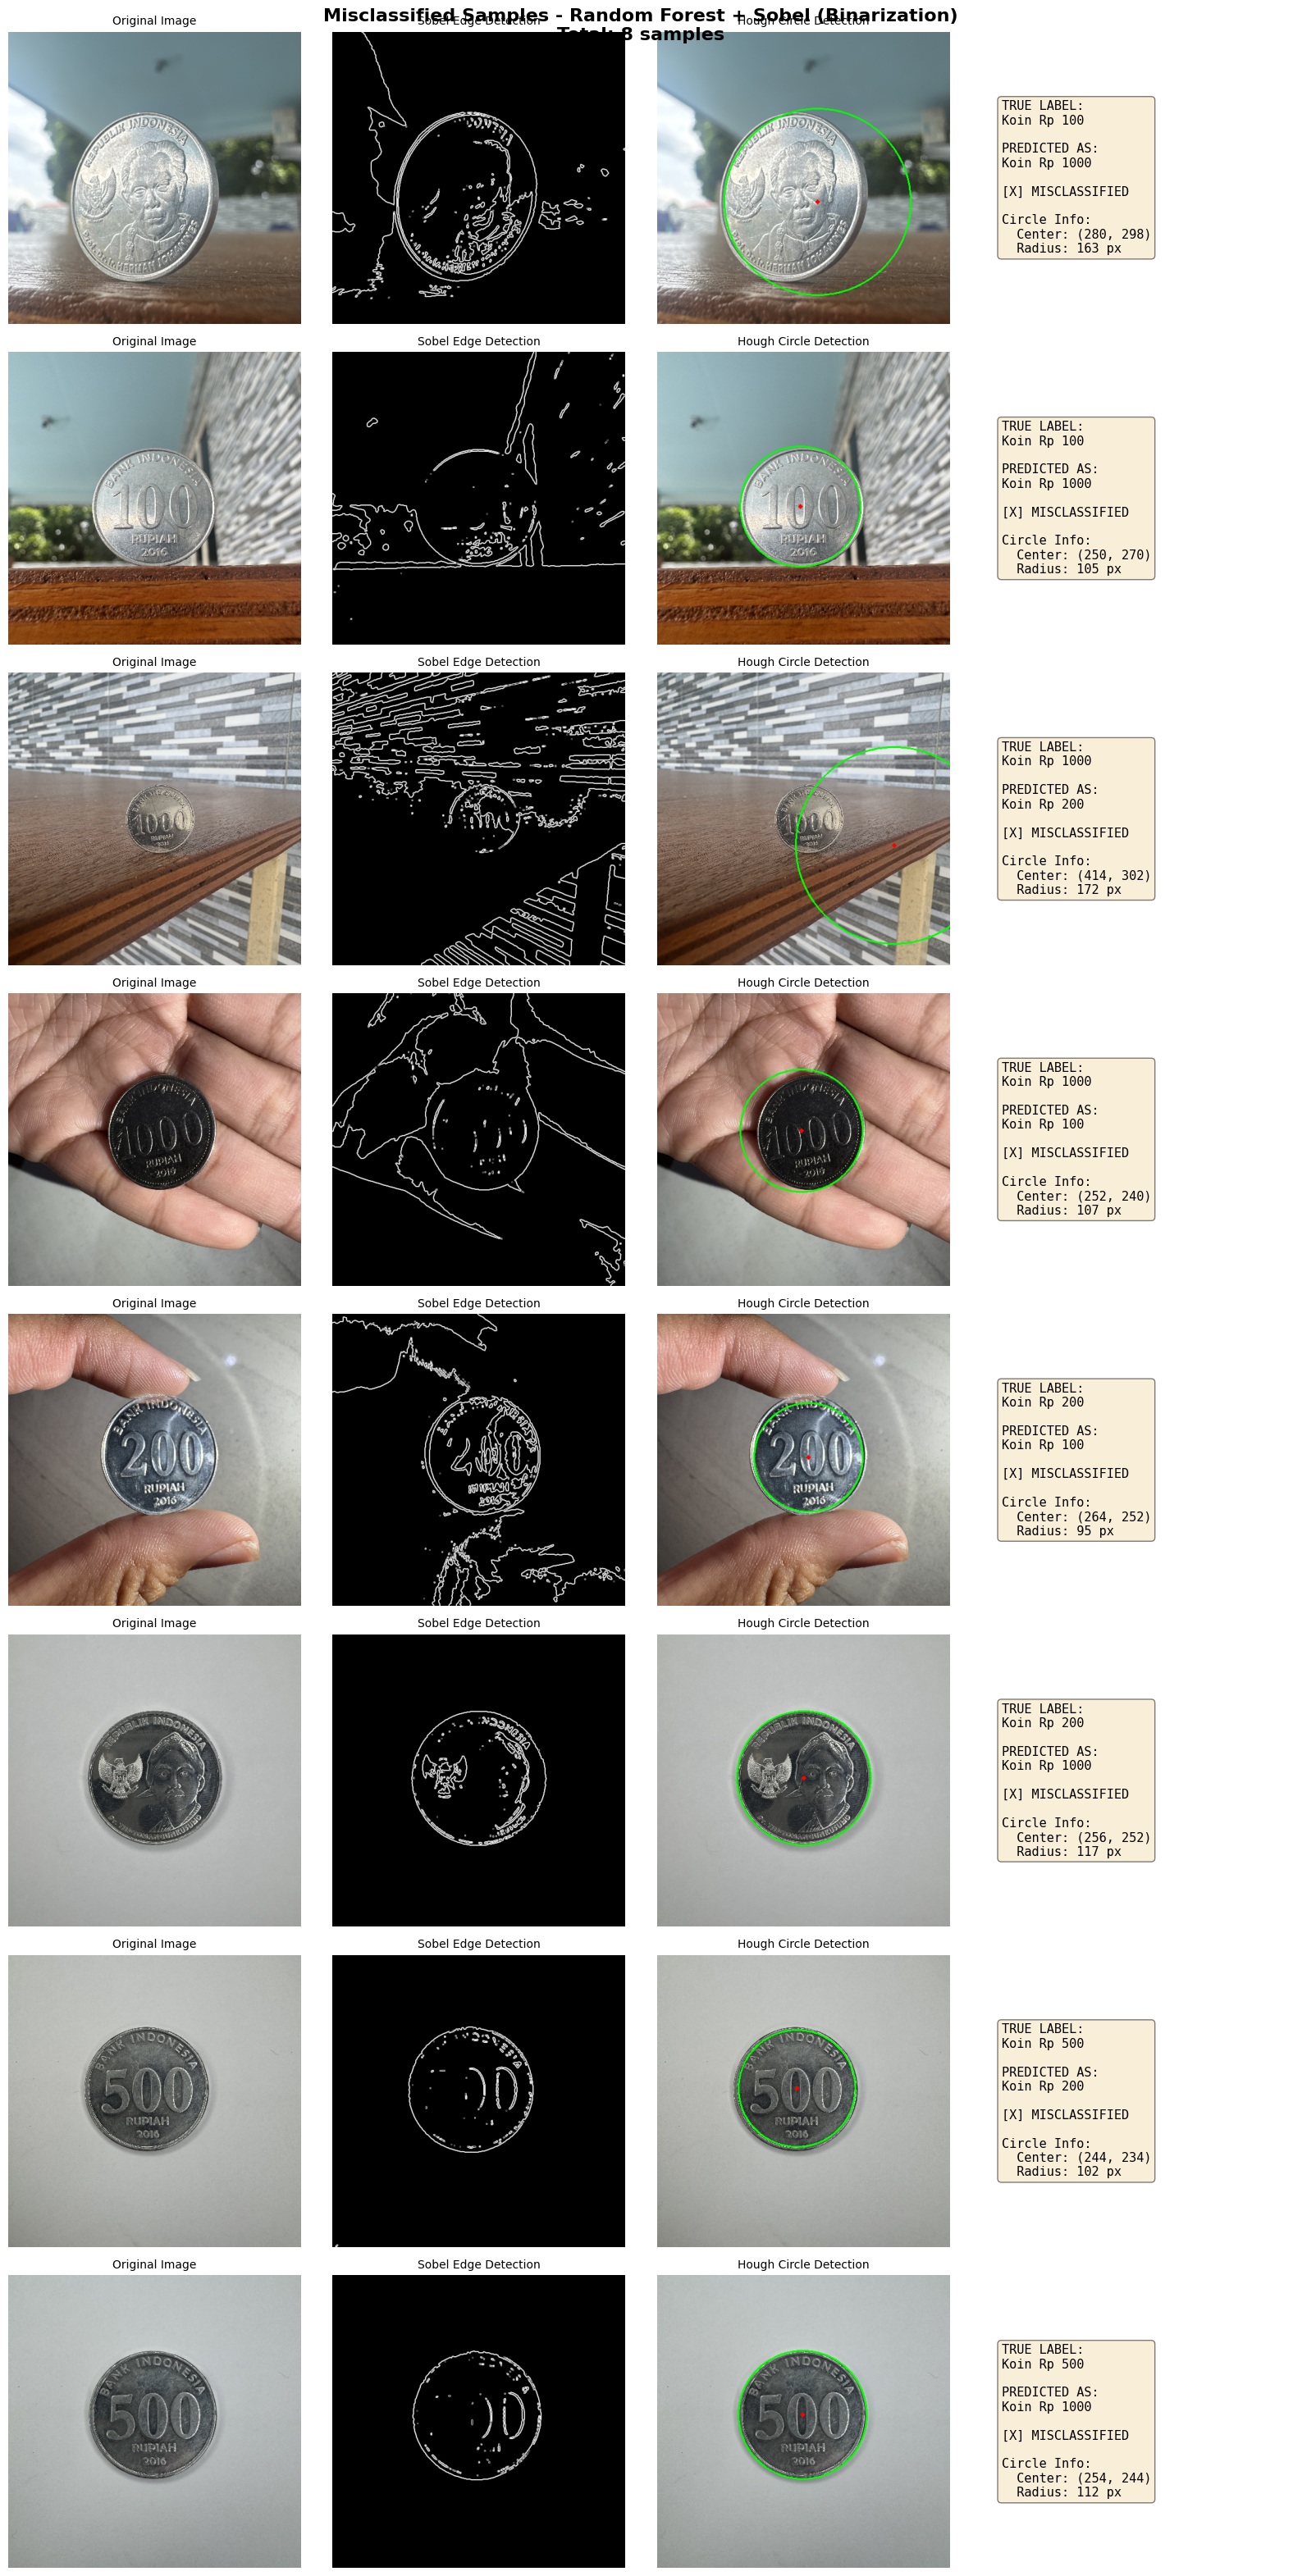


[OK] Visualisasi 8 sample yang salah diprediksi


In [27]:
# Visualisasi gambar yang salah diprediksi
if len(misclassified_samples) > 0:
    num_samples = len(misclassified_samples)
    cols = 4  # Original, Edges, Circle Detection, Info text
    
    fig, axes = plt.subplots(num_samples, cols, figsize=(16, num_samples * 4))
    
    # Handle case when only 1 row
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample in enumerate(misclassified_samples):
        img = sample['image']
        true_label = sample['true_label']
        pred_label = sample['pred_label']
        edges = sample['edges']
        circle_info = sample['circle_info']
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw circle
        img_with_circle = img.copy()
        if circle_info:
            x, y, r = circle_info
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 2)
            cv2.circle(img_with_circle, (x, y), 2, (0, 0, 255), 3)
        
        # Column 1: Original image
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title('Original Image', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Column 2: Sobel edges
        axes[idx, 1].imshow(edges, cmap='gray')
        axes[idx, 1].set_title('Sobel Edge Detection', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Column 3: Circle detection
        axes[idx, 2].imshow(cv2.cvtColor(img_with_circle, cv2.COLOR_BGR2RGB))
        axes[idx, 2].set_title('Hough Circle Detection', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Column 4: Info text
        axes[idx, 3].axis('off')
        info_text = f"TRUE LABEL:\n{class_names[true_label]}\n\n"
        info_text += f"PREDICTED AS:\n{class_names[pred_label]}\n\n"
        info_text += f"[X] MISCLASSIFIED\n\n"
        
        if circle_info:
            x, y, r = circle_info
            info_text += f"Circle Info:\n"
            info_text += f"  Center: ({x}, {y})\n"
            info_text += f"  Radius: {r} px"
        else:
            info_text += "Circle: Not detected"
        
        axes[idx, 3].text(0.1, 0.5, info_text, 
                         fontsize=11, 
                         verticalalignment='center',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                         family='monospace')
    
    plt.suptitle(f'Misclassified Samples - Random Forest + Sobel (Binarization)\nTotal: {num_samples} samples', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n[OK] Visualisasi {num_samples} sample yang salah diprediksi")
else:
    print("Tidak ada sample yang salah diprediksi! Model perfect!")

In [28]:
from collections import defaultdict

confusion_pairs = defaultdict(int)

for idx in misclassified_indices:
    true_label = y_test_sobel[idx]
    pred_label = y_pred_rf_sobel[idx]
    pair = f"{class_names[true_label]} → {class_names[pred_label]}"
    confusion_pairs[pair] += 1

print("Top confusion pairs:")
sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
for pair, count in sorted_pairs[:10]:
    print(f"  {pair}: {count}x")

Top confusion pairs:
  Koin Rp 1000 → Koin Rp 100: 25x
  Koin Rp 500 → Koin Rp 100: 23x
  Koin Rp 100 → Koin Rp 1000: 15x
  Koin Rp 200 → Koin Rp 100: 15x
  Koin Rp 100 → Koin Rp 500: 15x
  Koin Rp 500 → Koin Rp 1000: 15x
  Koin Rp 200 → Koin Rp 500: 14x
  Koin Rp 200 → Koin Rp 1000: 12x
  Koin Rp 100 → Koin Rp 200: 10x
  Koin Rp 1000 → Koin Rp 500: 10x
